# Tutoial 1 : Conditional Neural Processes - 1D GP Data

Last Update : 11 June 2019

**Aim**: 
- Training a simple [conditional neural process](https://arxiv.org/pdf/1807.01613.pdf) (CNP)
- Learning how to use the library to build more complicated models
- See how well a CNP "learns" a GP kernel

**Nota Bene:**
- Not much hyperparameter optimization done
- Architecture differs slightly from the paper to be more general and modularizable for future work.

**Environment Hypermarameters:**

In [1]:
N_THREADS = 8
# Nota Bene : notebooks don't deallocate GPU memory
IS_FORCE_CPU = False # can also be set in the trainer

## Environment

In [2]:
cd ..

/master


In [3]:
%autosave 600
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# CENTER PLOTS
from IPython.core.display import HTML
display(HTML(""" <style> .output_png {display: table-cell; text-align: center; margin:auto; }
.prompt display:none;}  </style>"""))

import os
if IS_FORCE_CPU:
    os.environ['CUDA_VISIBLE_DEVICES'] = ""

import sys
sys.path.append("notebooks")

import numpy as np
import matplotlib.pyplot as plt
import torch
torch.set_num_threads(N_THREADS)

Autosaving every 600 seconds


## Dataset

The dataset we will be using are simple functions sampled from different Gaussian kernel. See the docstrings of `GPDataset` for more details. 

**Details**
- 1 D inputs (x) and outputs (y)
- I will be using the following kernels ([Details in sklearn docs](https://scikit-learn.org/stable/modules/gaussian_process.html#kernels-for-gaussian-processes)), with hyperparameters from [sklearn examples](https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_prior_posterior.html#sphx-glr-auto-examples-gaussian-process-plot-gpr-prior-posterior-py): 
    - Squared Exponential
    - Matern
    - Exp-Sine-Squared (periodic)
    - Dot-Product (non-stationary and invariant to rotation around origin). 
- Points are sampled between (-5, 5) but scaled in (-1,1) as for inputs to the model (worked just as well without rescaling but slighlty easier to code for more advance things).
- The points are first sampled from a uniform grid then I add noise such that the final positions on not on a grid.
- At every epoch we precompute all the sampled functions, so the model never sees the same function twice.
- `num_points` is the number of sampled functions for a single sampled function
- `num_samples` is the number of sample functions which corresponds to the size of the datset for one epoch.

**Extensions**

- Adding a dataset from a new kernel is straightforward by definining your own [kernel](https://scikit-learn.org/stable/modules/gaussian_process.html#kernels-for-gaussian-processes).

In [4]:
from sklearn.gaussian_process.kernels import RBF, Matern, ExpSineSquared, DotProduct, ConstantKernel
from ntbks_viz import plot_posterior_samples, plot_prior_samples, plot_dataset_samples

from ntbks_datasets import GPDataset

In [5]:
X_DIM = 1  # 1D spatial input
Y_DIM = 1  # 1D regression
N_POINTS = 128
N_SAMPLES = 100000 # this is a lot and can work with less

In [6]:
datasets = dict()
kwargs = dict(n_samples=N_SAMPLES, n_points=N_POINTS)
datasets["rbf"] = GPDataset(kernel=1.0 * RBF(length_scale=1.0,
                                             length_scale_bounds=(1e-1, 10.0)),
                            **kwargs)

datasets["periodic"] = GPDataset(kernel=1.0 * ExpSineSquared(length_scale=1.0,
                                                             periodicity=3.0,
                                                             length_scale_bounds=(0.1, 10.0),
                                                             periodicity_bounds=(1.0, 10.0)),
                                 **kwargs)
datasets["non-stationary"] = GPDataset(kernel=(ConstantKernel(0.1, (0.01, 10.0)) *
                                               (DotProduct(sigma_0=1.0,
                                                           sigma_0_bounds=(0.1, 10.0)) ** 2)),
                                       **kwargs)
datasets["matern"] = GPDataset(kernel=1.0 * Matern(length_scale=1.0,
                                                   length_scale_bounds=(1e-1, 10.0),
                                                   nu=1.5),
                               **kwargs)

Let's visualize some of the uncoditional samples from the dataset:

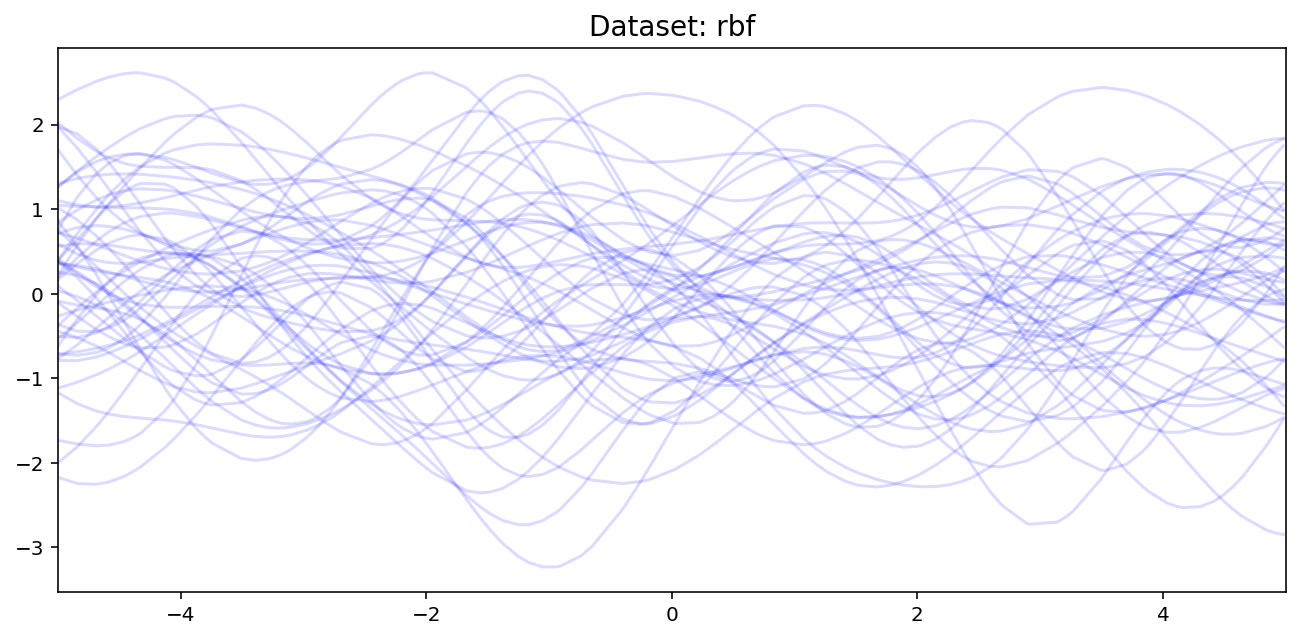

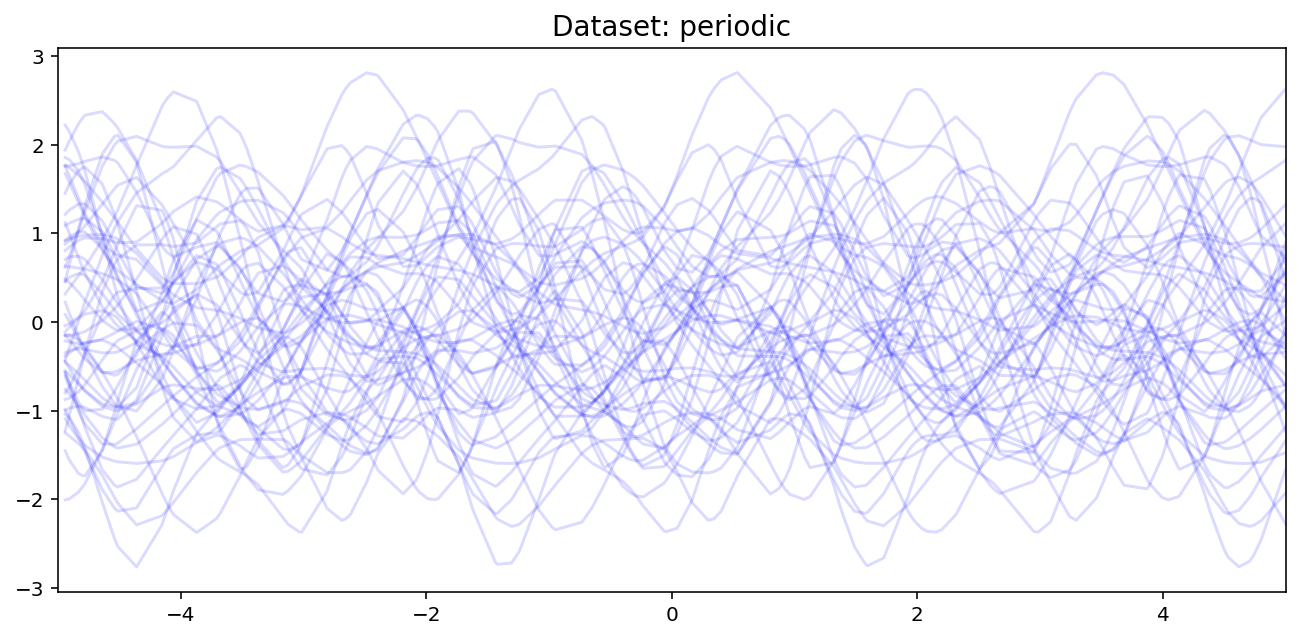

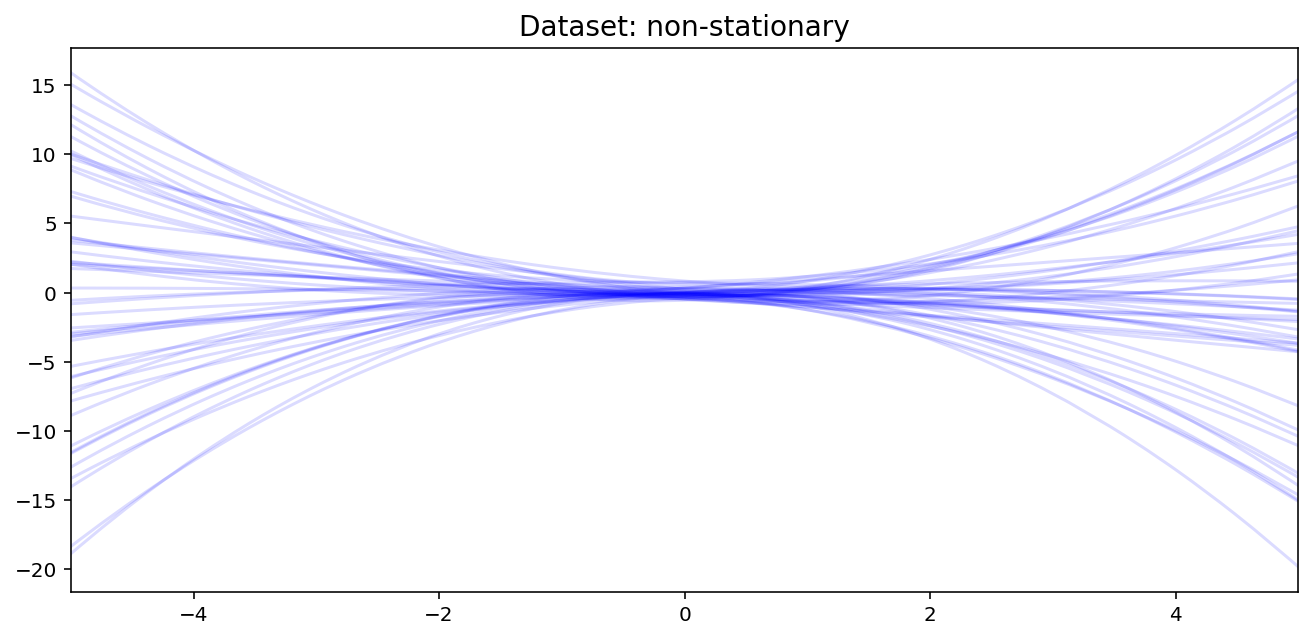

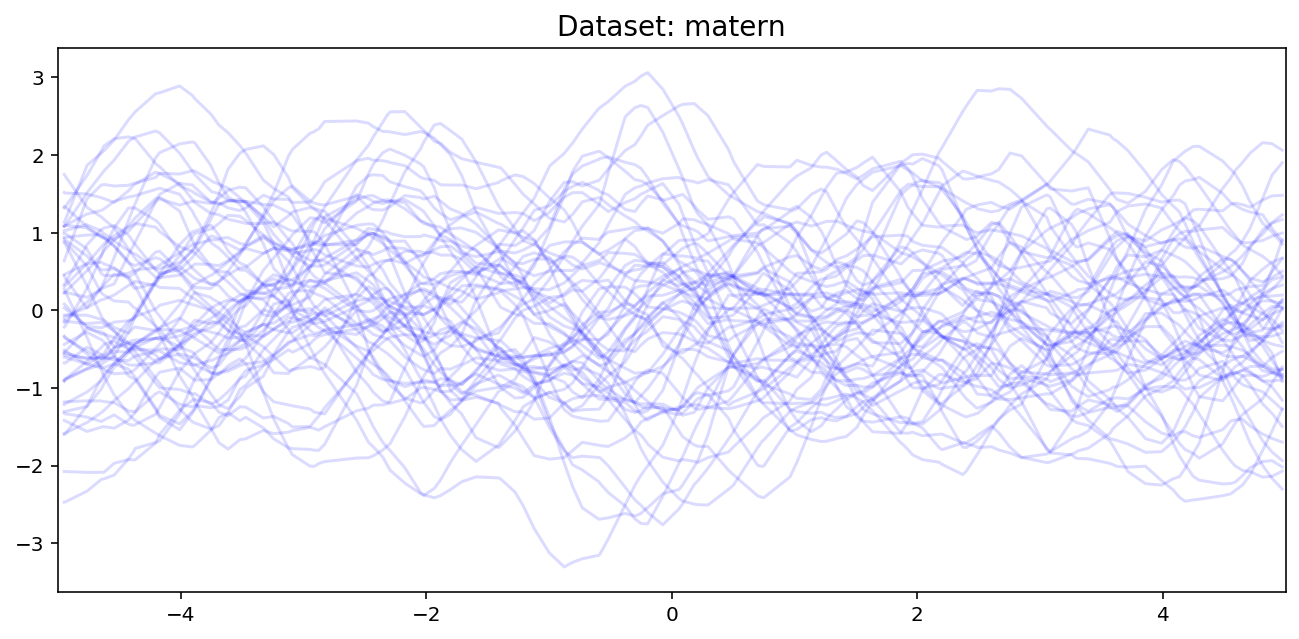

In [7]:
for k, dataset in datasets.items():
    plot_dataset_samples(dataset, title="Dataset: {}".format(k))

## Model

The general model architecture is slightly different from the paper to make it modular and easy to extend, but it is easy to make them equivalent with the right parameters. See the docstrings of `NeuralProcess` for more details. 


Nota Bene: Although hyperparameters have been tested I haven't ran any hyperparameter optimization yet. 

**Main Parameters : Conditional Neural Process**
- `r_dim` : Dimension of hidden representation.
- `XEncoder` : Spatial encoder module which maps $\{x^{(i)}\} \to \{x_{transformed}^{(i)}\}$. Example:
    - `MLP` : will learn positional embeddings with MLP
    - `SinusoidalEncodings` : use sinusoidal positional encodings.
    - `Identity` : this is what they use in the paper but it doesn't work as well
- `XYEncoder` : Encoder module which maps $\{x_{transformed}^{(i)}, y^{(i)}\} \to \{r^{(i)}\}$. Example:
    - `add_flat_input(MLP)` : learn representation with MLP (`add_flat_input` changes the constructor generaltity / compatibility)
    - `SelfAttentionBlock` : self attention mechanisms (as [Attentive Neural Process]). For more parameters (attention type, number of layers ...) refer to its docstrings.
- `Decoder` : Decoder module which maps $\{r, x^{(*)}\} \to \{\hat{y}^{(*)}\}$. Example:
    - `add_flat_input(MLP)` : predict with MLP.
    - `SelfAttentionBlock` : predict with self attention mechanisms to have coherant predictions (not use in attentive neural process [Attentive Neural Process], but in [image transformer][im transf]). 
- `aggregator` : Agregreator function which maps $\{r_i\} \to r$. To use a cross attention aggregation, use `AttentiveNeuralProcess` instead of `NeuralProcess`.
- `get_cntxt_trgt` :  Function that split the input into context and target points. Note: context points should be a subset of target ones.
- `PredicitiveDistribution` : Predictive distribution, e.g. `Normal`, `Laplace`, ....


**Additional Parameters : (Attentive) Neural Process**

- `encoded_path` : Which path(s) to use:
    - `"deterministic"` uses a [Conditional Neural Process] (no latents), where the decoder gets a deterministic representation as input (function of the context). 
    - `"latent"` uses a [Neural Process], where the decoder gets a sample latent representation as input (function of the target during training and context during test).
    - If `"both"` concatenates both representations as described in [Attentive Neural Process].
- `LatentEncoder` : Encoder which maps $r \to [\mu_z; f(\sigma_z)]$. Only used if `encoded_path` in `["latent", "both"]`.

To use cross-attention instead of aggregation (i.e. [Attentive Neural Process]) replace `NeuralProcess` with `AttentiveNeuralProcess`. Many different attention mechanisms are available (image transformer, multihead, dot head, manhattan ...), see its docstrings for more details. 
    

**Extensions**

- For Neural Process, see the [Tutorial 2 - Neural Process] notebook.
- For Attentive Neural Process, see the [Tutorial 3 - Attentive Neural Process] notebook.
- Bayesian Hyperparameter Optimization is easy to run as the library is a wrapper around sklearn. To do so use `BayesSearchCV` from [skopt](https://scikit-optimize.github.io) which is in *requirements.txt* ([example](https://scikit-optimize.github.io/notebooks/sklearn-gridsearchcv-replacement.html))

[Neural Process]: https://arxiv.org/abs/1807.01622
[Conditional Neural Process]: https://arxiv.org/pdf/1807.01613.pdf
[Attentive Neural Process]: https://arxiv.org/abs/1901.05761
[Image Transformer]: https://arxiv.org/abs/1802.05751
[Tutorial 2 - Neural Process]: Tutorial%202%20-%20Neural%20Process.ipynb
[Tutorial 3 - Attentive Neural Process]: Tutorial%203%20-%20Attentive%20Neural%20Process.ipynb

In [8]:
from torch.distributions import Normal

from skssl.transformers import (NeuralProcessLoss, NeuralProcess, AttentiveNeuralProcess, 
                                SelfAttentionBlock, SinusoidalEncodings)
from skssl.predefined import MLP, add_flat_input, DeepMLP
from skssl.transformers.neuralproc.datasplit import context_target_split

In [9]:
R_DIM = 128
RANGE_CNTXT = (4, 50)  # context points will be sampled uniformly in this range
RANGE_EXTRA_TRGTS = (3, N_POINTS-RANGE_CNTXT[1])  # extra number of targtes points 

In [10]:
def get_cntxt_trgt(*args):
    return context_target_split(*args, range_cntxts=RANGE_CNTXT, range_extra_trgts=RANGE_EXTRA_TRGTS)

def init_model():
    return NeuralProcess(X_DIM, Y_DIM,
                         XEncoder=MLP, # encoding X (not done in the paper) improves the results
                         XYEncoder=add_flat_input(DeepMLP),  # no self attention encoder (3 hidden layer MLP)
                         Decoder=add_flat_input(DeepMLP), # no self attention decoder (3 hidden layer MLP)
                         r_dim=R_DIM,
                         get_cntxt_trgt=get_cntxt_trgt,
                         aggregator=torch.mean,
                         PredictiveDistribution=Normal, # Gaussian predictive distribution
                         encoded_path="deterministic") # use CNP

In [11]:
# initialize one model for each dataset
data_models = {name: (init_model(), data) 
               for name, data in datasets.items()}

### N Param

Number of parameters (note that I did not play around with this much, this depends a lot on the representation size):

In [12]:
from utils.helpers import count_parameters

In [13]:
for k, (neural_proc, dataset) in data_models.items():
    print("N Param:", count_parameters(neural_proc))
    break

N Param: 136642


### Prior Samples
We can visualize the prior (i.e. the output of the neural process without any context points) before training.

std: 0.2505730235576629


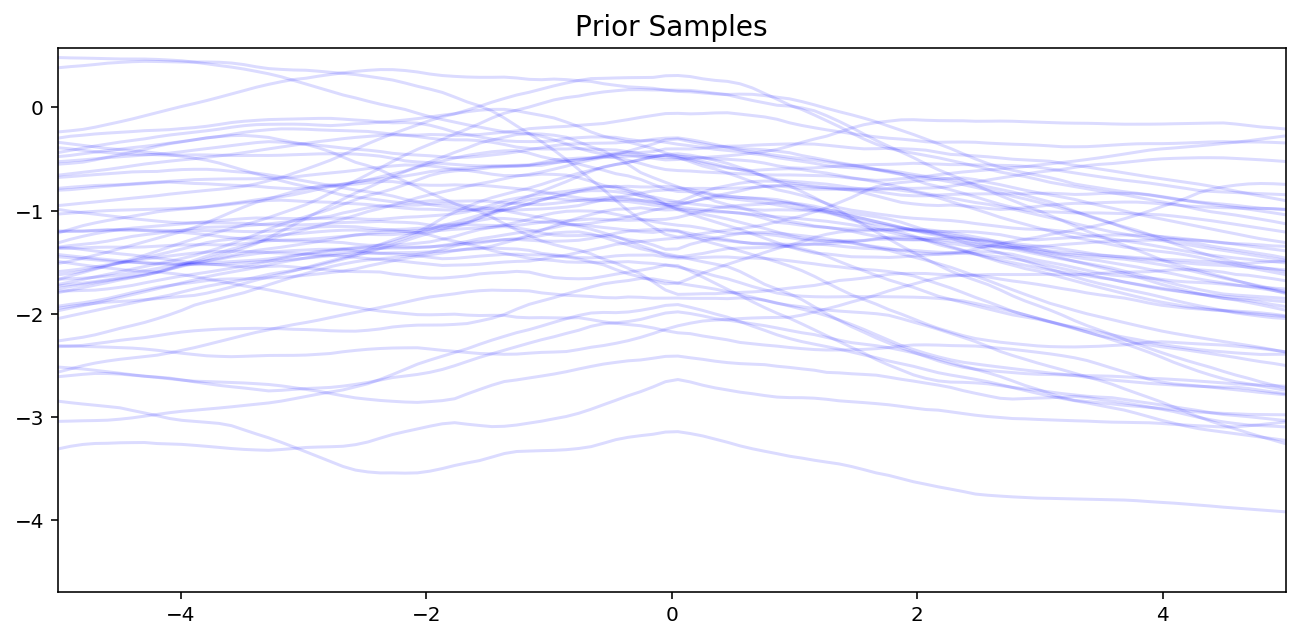

In [14]:
for k, (neural_proc, dataset) in data_models.items():
    plot_prior_samples(neural_proc, train_min_max=dataset.min_max)
    # all the models at the start are "similar" so plot only one
    break

# Training

Training is handled by [skorch](https://github.com/skorch-dev/skorch), which is a sklearn-style wrapper around pytorch. The framework is slightly modified to enable semi-supervised learning. Refer to the docs (and `skssl.training`) for more details.

**Highltights**
- sklearn-style wrapper around pytorch. this is especially handy for downstream tasks to make a pipeline which does a task after being represented (i.e. transformed in sklearn jargon) by a CNP.
- many nice callbacks (including best model checkpoint used below)
- you can interrupt training and run again a cell: it will start where it last stoped


In [15]:
from skorch.callbacks import ProgressBar, Checkpoint

from skssl.training import NeuralNetTransformer
from skssl.training.helpers import make_Xy_input

In [16]:
N_EPOCHS = 50
BATCH_SIZE = 64
is_RETRAIN = True # if false load precomputed

In [17]:
for k,(neural_proc, dataset) in data_models.items():
    print()
    print("--- {} {} ---".format("Training" if is_RETRAIN else "Loading", k))
    print()
    
    chckpt = Checkpoint(dirname="results/notebooks/neural_process/cnp_{}".format(k), 
                        monitor='train_loss_best') # train would be same as validation as always resamples
    
    model = NeuralNetTransformer(neural_proc, NeuralProcessLoss,
                                 max_epochs=N_EPOCHS,
                                 batch_size=BATCH_SIZE,
                                 train_split=None,  # don't use cross validation dev set
                                 lr=1e-3, # they use 5e-5 but when no latent can increase lr
                                 callbacks=[ProgressBar(), 
                                            chckpt], # checkpoint best model
                                ) 
    
    if is_RETRAIN:
        _=model.fit(*make_Xy_input(dataset))

    # load in all case => even when training loads the best checkpoint
    model.initialize()
    model.load_params(checkpoint=chckpt)


--- Training rbf ---



  epoch    train_loss    cp      dur
-------  ------------  ----  -------
      1      132.3189     +  17.9361


      2       89.3505     +  17.9607


      3       68.1827     +  17.6775


      4       51.3360     +  16.8492


      5       36.1101     +  16.7713


      6       23.2525     +  16.2216


      7       13.3370     +  17.1582


      8        5.1962     +  17.1825


      9       -4.0323     +  16.7297


     10       -8.0383     +  16.8078


     11      -13.3612     +  17.7141


     12      -20.4238     +  16.5529


     13      -21.5963     +  17.1173


     14      -24.3661     +  17.3451


     15      -27.7618     +  16.4482


     16      -32.1255     +  16.2525


     17      -34.2483     +  16.1297


     18      -36.1580     +  18.4743


     19      -34.9866        18.3881


     20      -37.5116     +  17.8028


     21      -37.9219     +  18.5287


     22      -40.6010     +  17.2411


     23      -41.7214     +  16.4775


     24      -43.8689     +  17.6755


     25      -49.6239     +  18.2227


     26      -47.4079        18.1016


     27      -48.3278        18.8803


     28      -43.9318        17.8095


     29      -47.3163        18.3395


     30      -52.8251     +  18.2980


     31      -49.2309        18.3459


     32      -51.4264        18.1188


     33      -50.6946        18.4517


     34      -51.8924        18.3636


     35      -55.5333     +  18.5158


     36      -53.2193        19.0140


     37      -55.3028        18.4798


     38      -54.8218        17.6481


     39      -55.6883     +  17.5544


     40      -61.1655     +  18.1756


     41      -54.8489        17.7797


     42      -56.1867        15.8477


     43      -60.3714        14.8031


     44      -61.9912     +  13.7825


     45      -57.2039        15.1682


     46      -62.5908     +  14.5736


     47      -60.4822        15.2513


     48      -57.7229        14.0271


     49      -58.8195        14.3988


     50      -59.9253        14.6800

--- Training periodic ---



  epoch    train_loss    cp      dur
-------  ------------  ----  -------
      1      135.6470     +  15.2636


      2      116.3698     +  15.0577


      3       84.7918     +  15.5581


      4       72.1398     +  15.0683


      5       56.1770     +  15.3300


      6       40.8299     +  14.4330


      7       33.2956     +  15.4027


      8       23.3322     +  14.8745


      9       18.7853     +  15.5930


     10       14.6958     +  15.4209


     11        9.9189     +  15.2221


     12        3.5808     +  15.2557


     13        0.2626     +  15.6710


     14       -2.6547     +  15.4107


     15       -9.2802     +  15.2000


     16      -13.8225     +  15.4747


     17      -15.0035     +  13.9964


     18      -17.9291     +  15.2262


     19      -17.0178        15.0168


     20      -21.0157     +  15.4132


     21      -21.3107     +  15.2738


     22      -25.8675     +  15.9061


     23      -28.4379     +  14.8181


     24      -34.0923     +  15.3137


     25      -36.2229     +  14.3090


     26      -37.8380     +  14.5327


     27      -33.3742        13.5725


     28      -34.2325        11.5947


     29      -35.3476        13.9425


     30      -40.4378     +  13.5139


     31      -41.6572     +  12.7926


     32      -38.0741        13.5582


     33      -37.0682        11.5421


     34      -42.4054     +  12.9292


     35      -48.2952     +  13.3578


     36      -45.6183        13.8631


     37      -45.0281        12.9271


     38      -47.9233        11.3645


     39      -50.3354     +  14.4942


     40      -52.2942     +  13.3886


     41      -46.1478        14.4053


     42      -49.1084        14.8152


     43      -57.4969     +  13.3725


     44      -56.2555        13.6312


     45      -55.8085        13.7777


     46      -55.2148        13.0822


     47      -53.9697        14.8214


     48      -49.1851        13.6346


     49      -55.0246        13.6234


     50      -54.6035        14.0915

--- Training non-stationary ---



  epoch    train_loss    cp      dur
-------  ------------  ----  -------
      1      115.9272     +  14.3401


      2       19.8987     +  16.0988


      3       -8.5684     +  15.3818


      4      -25.3586     +  15.8878


      5      -38.9455     +  15.2706


      6      -45.7496     +  16.0278


      7      -49.4961     +  15.4097


      8      -54.7823     +  15.5404


      9      -58.3659     +  15.6892


     10      -59.7001     +  15.5637


     11      -62.3269     +  15.9152


     12      -66.2950     +  15.8989


     13      -68.0933     +  15.6148


     14      -69.8936     +  15.3663


     15      -73.1654     +  16.1046


     16      -75.6846     +  15.0708


     17      -74.6391        13.9549


     18      -76.0985     +  15.6241


     19      -79.2199     +  15.6689


     20      -74.9709        16.3430


     21      -67.9709        14.8866


     22      -80.4256     +  15.9128


     23      -78.6882        16.2069


     24      -84.1827     +  15.4581


     25      -81.2952        14.3166


     26      -80.2699        14.8484


     27      -85.2332     +  15.4551


     28      -79.0264        13.9417


     29      -84.6197        14.5376


     30      -88.9171     +  15.9052


     31      -86.9867        14.3493


     32      -84.2558        14.8274


     33      -88.1680        15.7876


     34      -85.9741        15.6242


     35      -92.4038     +  14.3507


     36      -88.9569        15.5598


     37      -94.8862     +  14.4622


     38      -90.2809        15.6990


     39      -93.4542        14.9423


     40      -94.0290        13.3754


     41      -89.7362        15.1556


     42      -94.0814        15.7411


     43      -96.0861     +  16.2881


     44      -95.0207        14.6586


     45      -94.8539        15.6516


     46      -99.1866     +  14.7096


     47      -93.3197        15.6661


     48      -91.6427        15.5711


     49      -92.1453        15.2730


     50      -98.5050        16.3160

--- Training matern ---



  epoch    train_loss    cp      dur
-------  ------------  ----  -------
      1      126.5023     +  14.3296


      2       95.5950     +  14.1005


      3       78.6658     +  14.9778


      4       70.1055     +  15.7268


      5       59.9655     +  14.2727


      6       54.8406     +  14.7955


      7       51.7820     +  14.8506


      8       47.0294     +  15.2327


      9       43.4195     +  15.4809


     10       42.1937     +  15.3881


     11       39.2438     +  14.9452


     12       34.3406     +  14.8801


     13       33.9646     +  15.0290


     14       32.3855     +  14.4869


     15       30.4722     +  14.0168


     16       27.3846     +  15.3743


     17       24.9069     +  15.7474


     18       25.0758        14.3126


     19       24.8333     +  16.1561


     20       23.2791     +  15.8048


     21       23.0364     +  15.8092


     22       21.5850     +  14.1866


     23       20.4328     +  14.0454


     24       19.9380     +  15.6856


     25       13.9834     +  15.1078


     26       17.0476        15.3447


     27       14.4004        16.0758


     28       17.4633        13.6909


     29       15.8781        13.5790


     30       12.4264     +  16.1223


     31       13.9112        15.3369


     32       13.7528        15.4565


     33       12.4211     +  14.4754


     34       11.7798     +  15.5990


     35       10.6399     +  14.8994


     36       11.2883        14.9691


     37        8.0985     +  15.2140


     38        9.0373        15.0190


     39        9.0438        16.3513


     40        6.4069     +  15.3806


     41       10.0728        14.9491


     42       11.1953        14.6355


     43        6.3682     +  15.2511


     44        6.7954        15.9167


     45        7.8609        14.3230


     46        4.1251     +  15.3356


     47        5.0784        14.6305


     48        8.0294        13.7890


     49        4.4919        15.1188


     50        4.7060        15.9755


In [ ]:
for k,(neural_proc, dataset) in data_models.items():
    print()
    print("--- {} {} ---".format("Training" if is_RETRAIN else "Loading", k))
    print()
    
    chckpt = Checkpoint(dirname="results/notebooks/neural_process/cnp_{}".format(k), 
                        monitor='train_loss_best') # train would be same as validation as always resamples
    
    model = NeuralNetTransformer(neural_proc, NeuralProcessLoss,
                                 max_epochs=N_EPOCHS,
                                 batch_size=BATCH_SIZE,
                                 train_split=None,  # don't use cross validation dev set
                                 lr=1e-3, # they use 5e-5 but when no latent can increase lr
                                 callbacks=[ProgressBar(), 
                                            chckpt], # checkpoint best model
                                ) 
    
    if is_RETRAIN:
        _=model.fit(*make_Xy_input(dataset))
    else:
        model.initialize()
        model.load_params(checkpoint=chckpt)

# Inference

## Trained Prior

The prior should now encode some information about the shapes of the functions. Neural processes can be thought of methods that learn a kernel functions from the data, if they are effective teh trained prior should thus be very similar to the the samples the datasets previously seen.

In [18]:
EXTRAP_DISTANCE = 2  # add 2 to the right for extrapolation
INTERPOLATION_RANGE = dataset.min_max
EXTRAPOLATION_RANGE = (dataset.min_max[0], dataset.min_max[1]+EXTRAP_DISTANCE )

std: 1.588501034975052
std: 1.657714249491692
std: 2.491806813776493
std: 1.6577138173580166


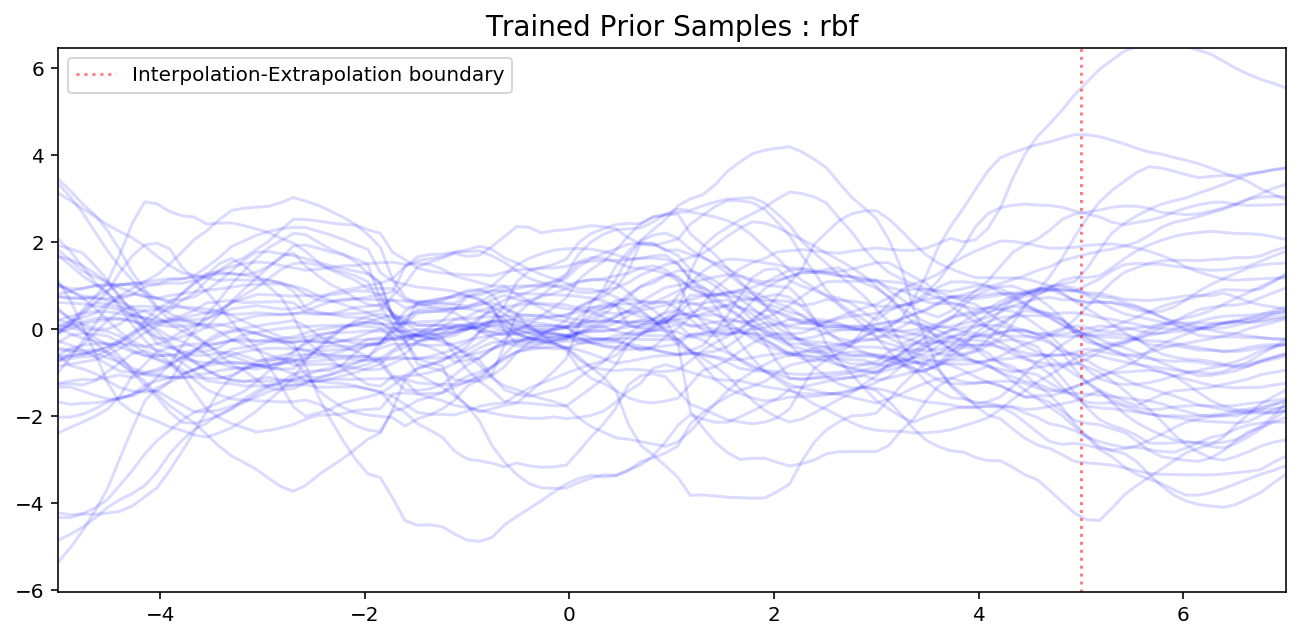

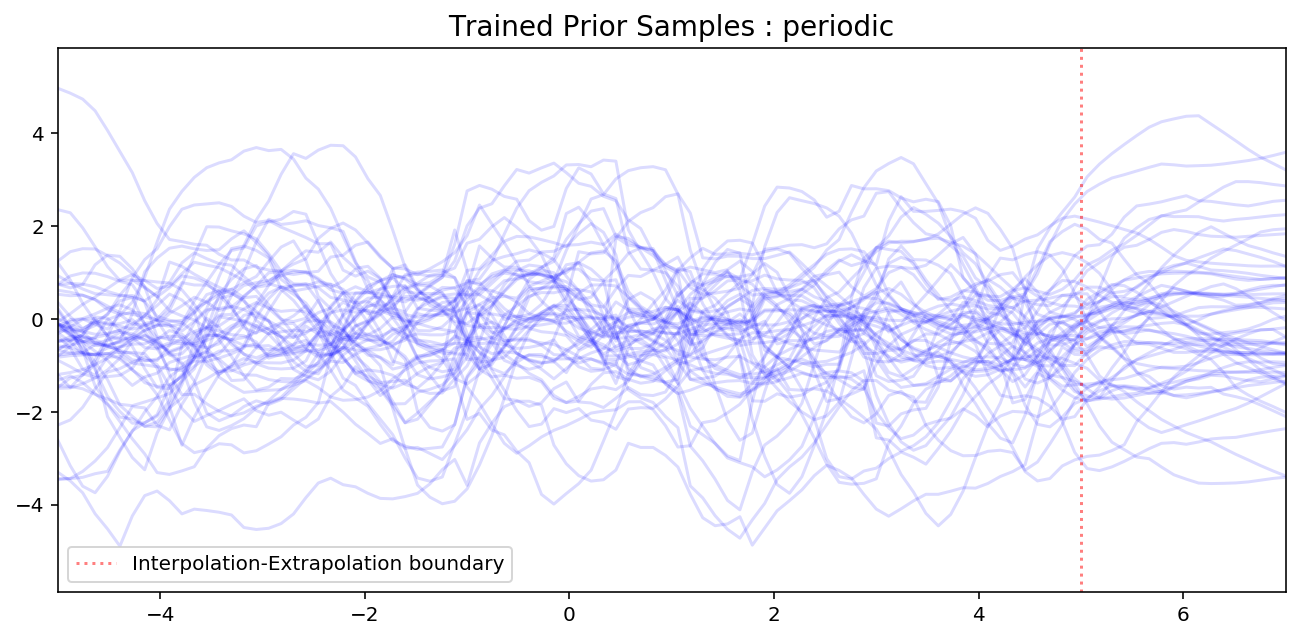

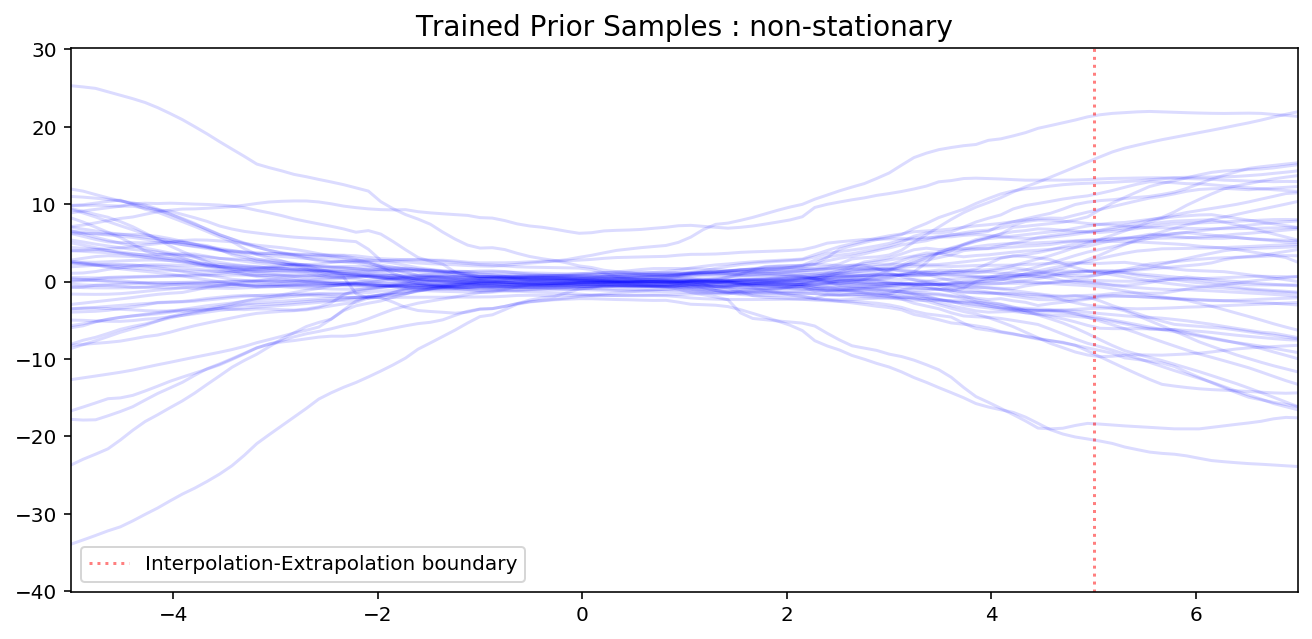

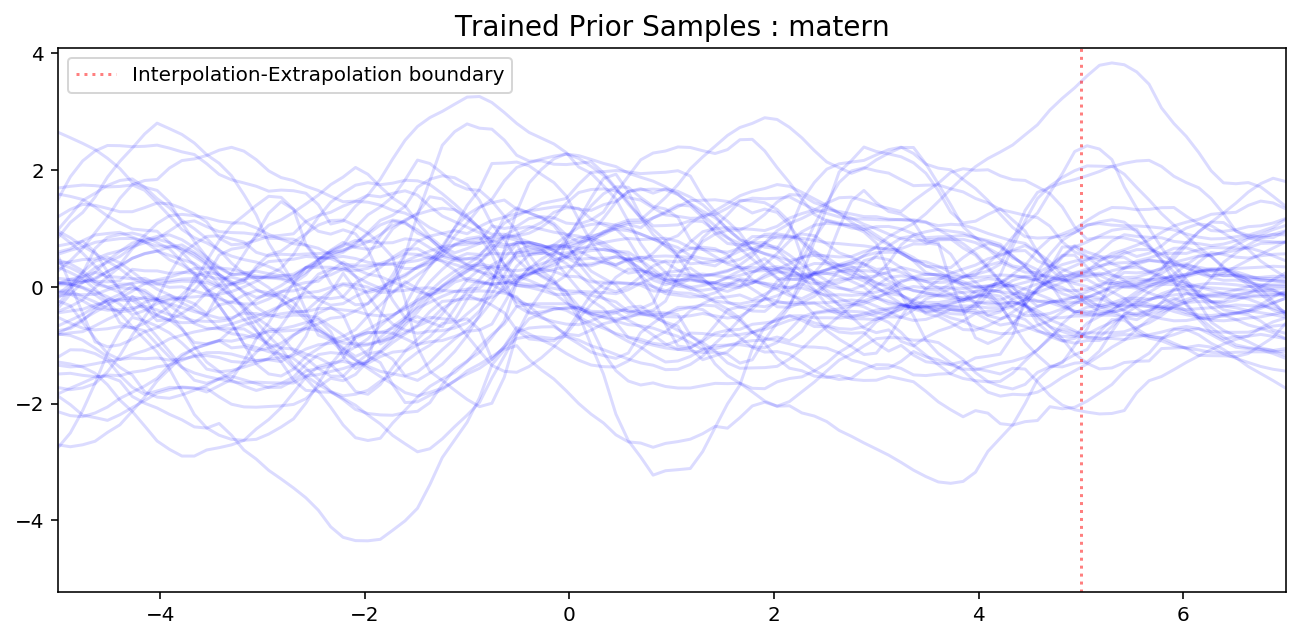

In [19]:
for k,(neural_proc, dataset) in data_models.items():
    plot_prior_samples(neural_proc, 
                       title="Trained Prior Samples : {}".format(k), 
                       test_min_max=EXTRAPOLATION_RANGE, 
                       train_min_max=INTERPOLATION_RANGE)

We see that the trained priors are not too bad but cannot learn very smooth samples (e.g. for all besides Matern).

## Posterior

Let us now investigate the posterior over functions when conditioned on some new context points.

std: 0.4591219425201416
std: 0.4492340087890625
std: 0.5205673575401306
std: 0.8202899098396301


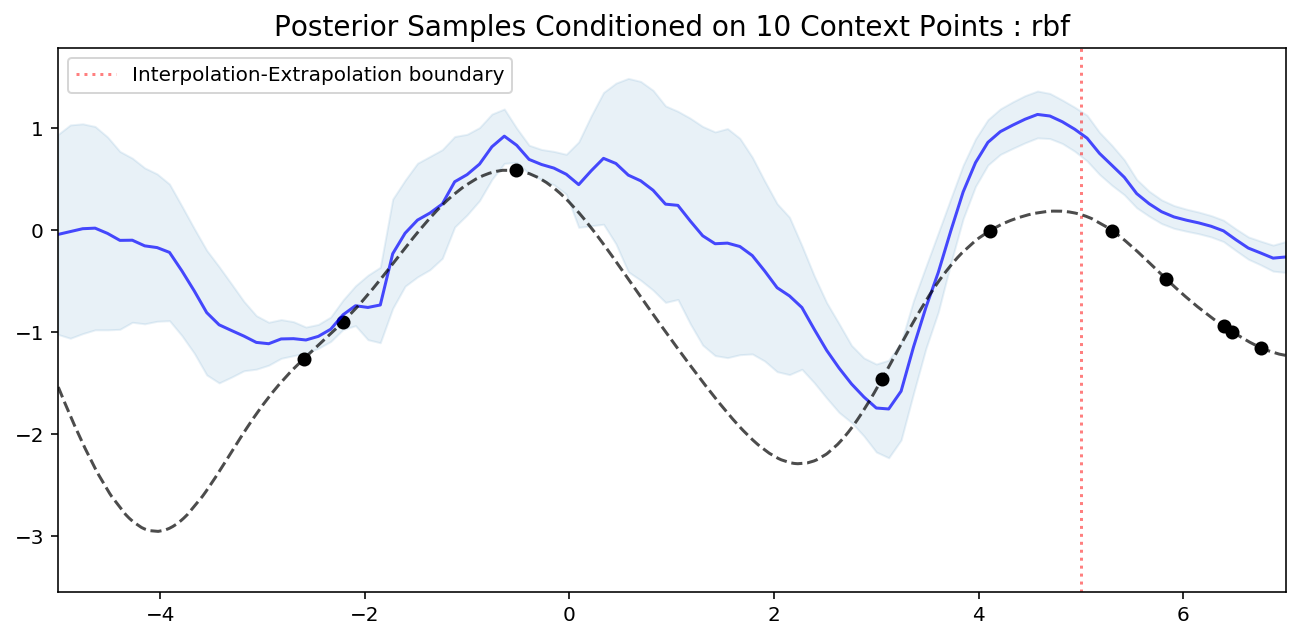

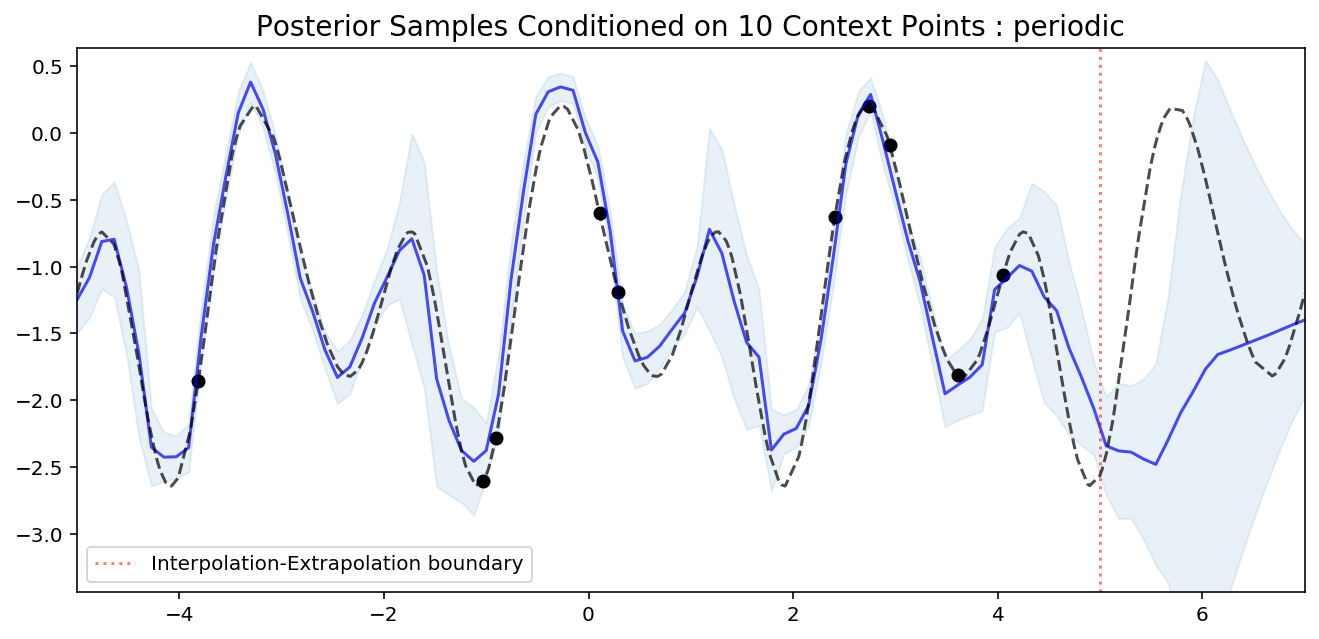

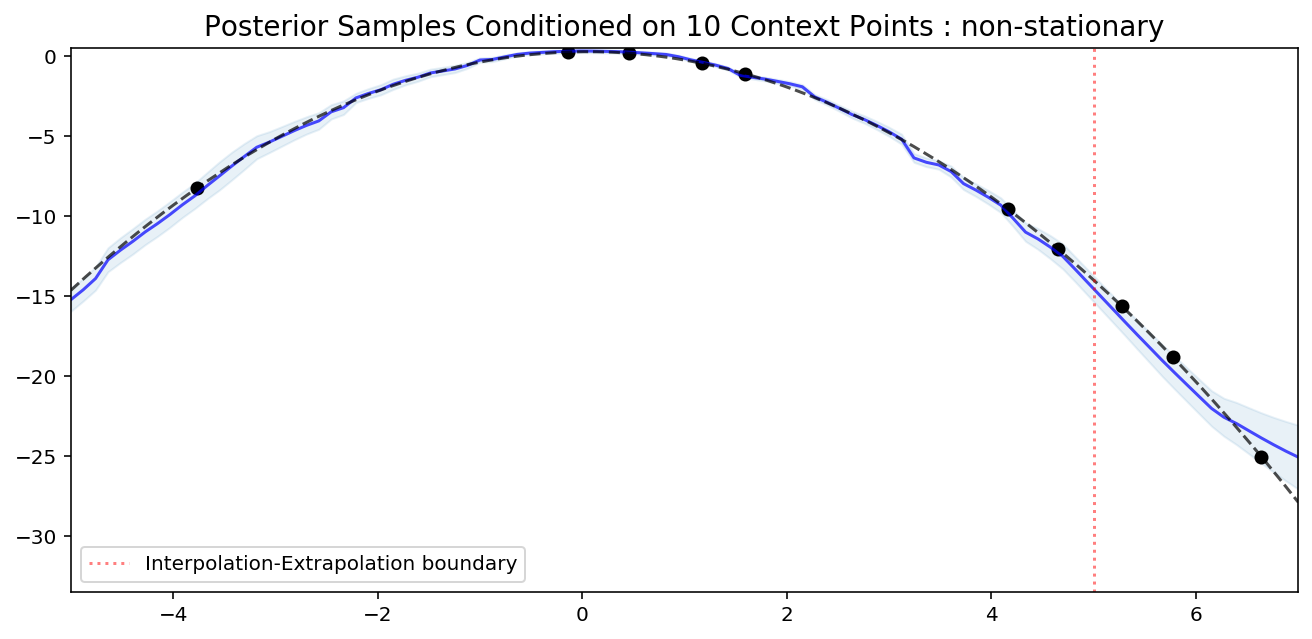

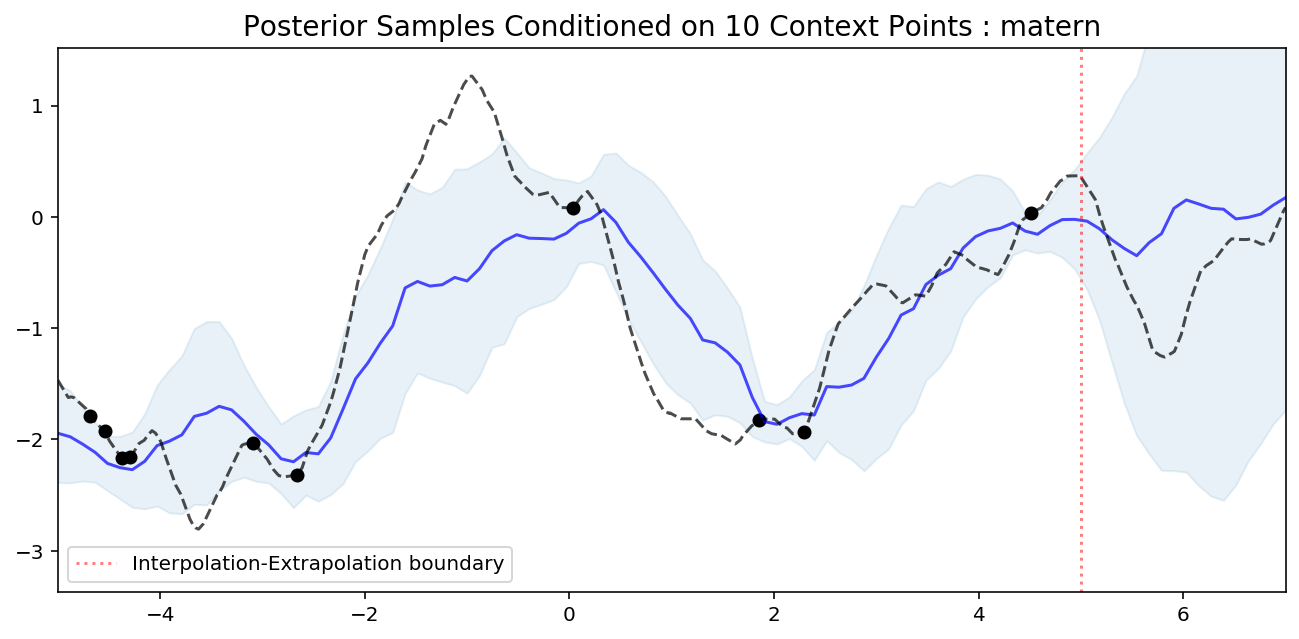

In [20]:
N_CNTXT = 10
for k,(neural_proc, dataset) in data_models.items():
    plot_posterior_samples(dataset, neural_proc, 
                           n_cntxt=N_CNTXT, 
                           test_min_max=EXTRAPOLATION_RANGE, 
                           n_points=2*N_POINTS,
                           n_samples=1,
                           title="Posterior Samples Conditioned on {} Context Points : {}".format(N_CNTXT, k))

To have a better understanding of uncertainty let's look at only 2 context points:

std: 1.0848807096481323
std: 0.8504058718681335
std: 1.5818065404891968
std: 0.9567174315452576


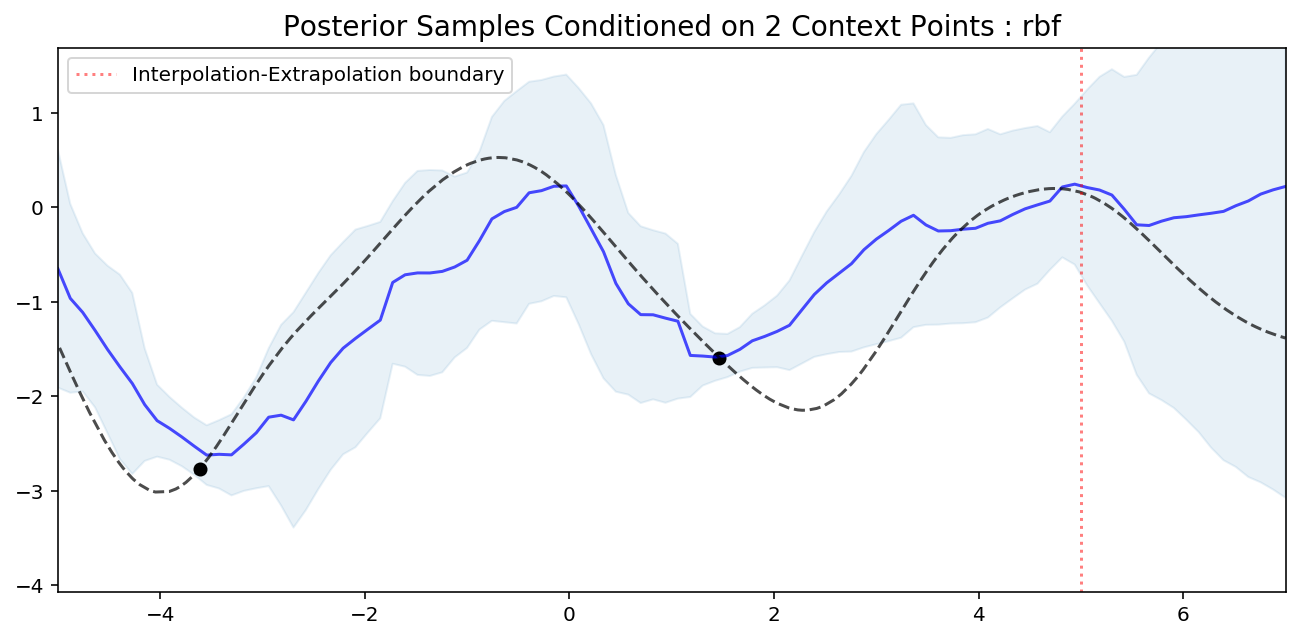

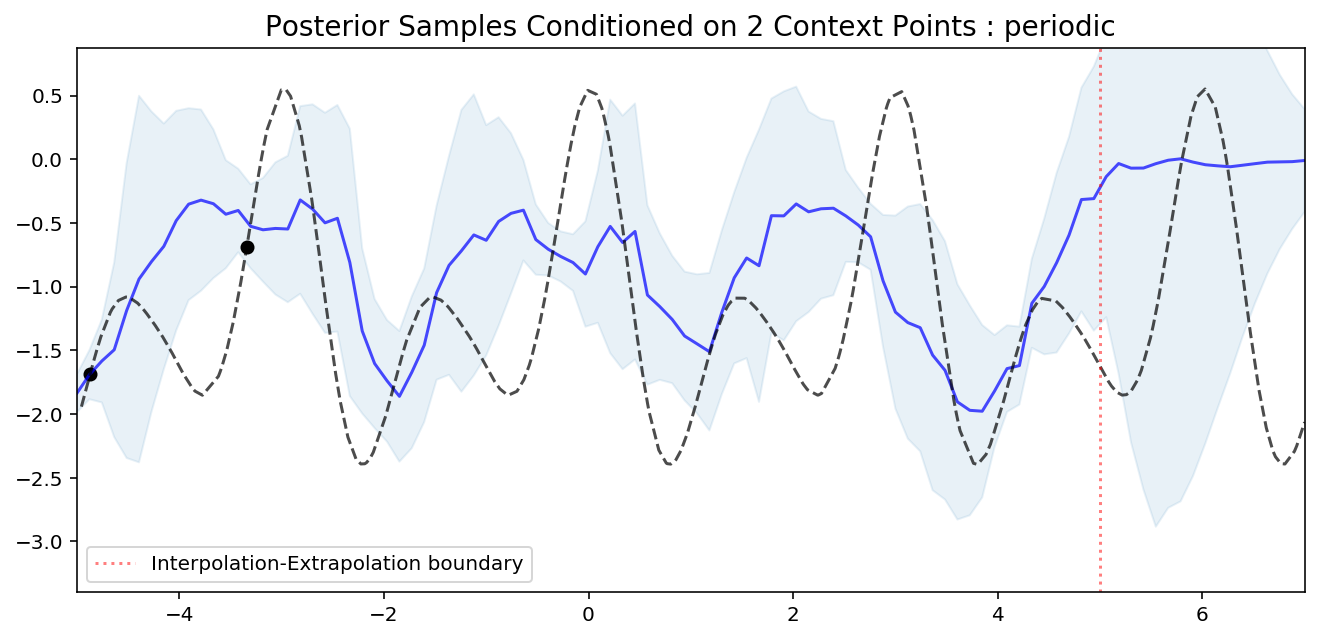

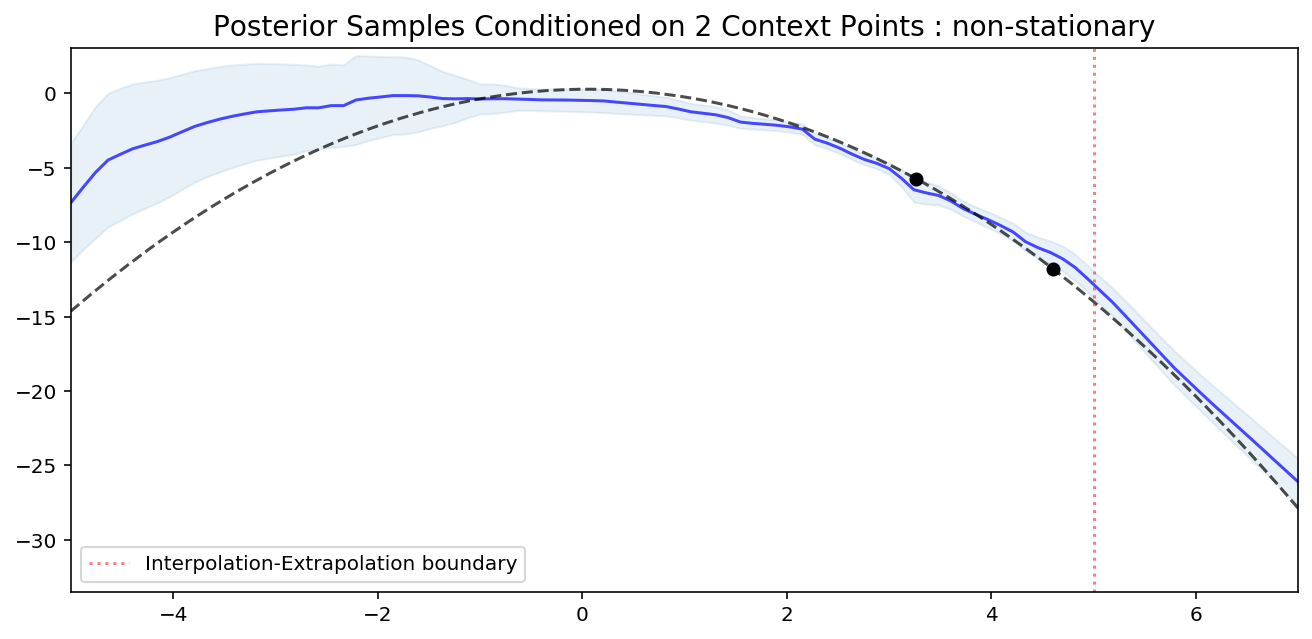

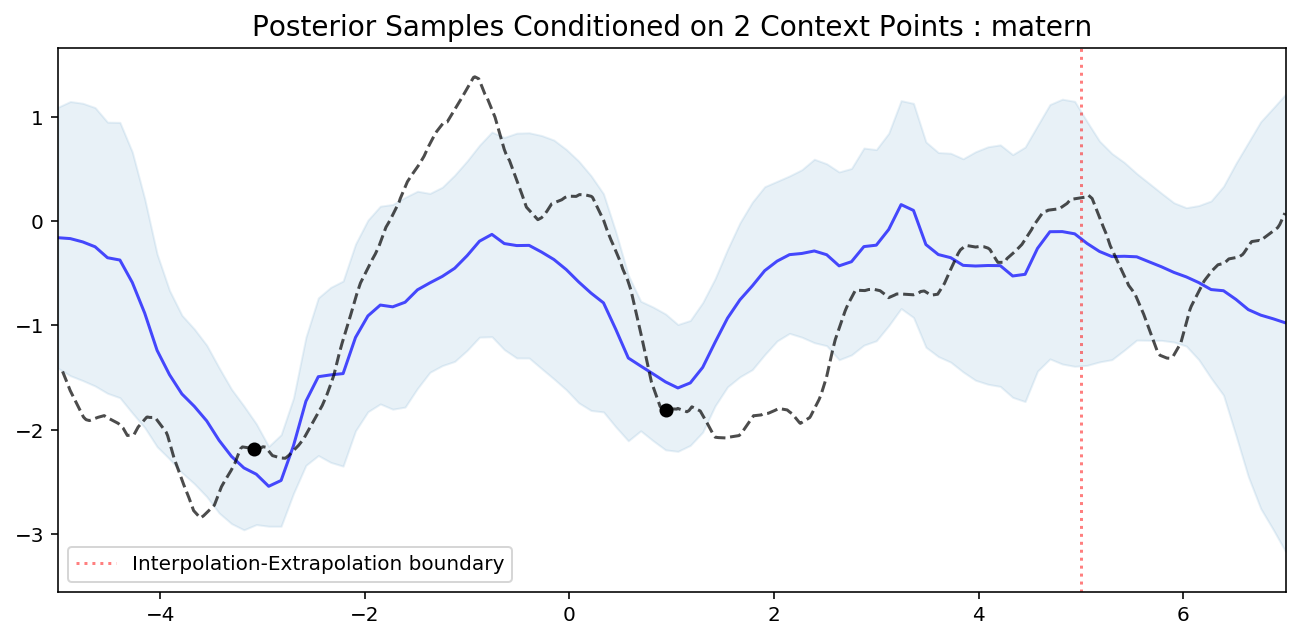

In [21]:
N_CNTXT = 2
for k,(neural_proc, dataset) in data_models.items():
    plot_posterior_samples(dataset, neural_proc, 
                           n_cntxt=N_CNTXT, 
                           test_min_max=EXTRAPOLATION_RANGE, 
                           n_points=2*N_POINTS,
                           n_samples=1,
                           title="Posterior Samples Conditioned on {} Context Points : {}".format(N_CNTXT, k))

std: 0.2694060802459717
std: 0.23666095733642578
std: 0.33729949593544006
std: 0.3970007598400116


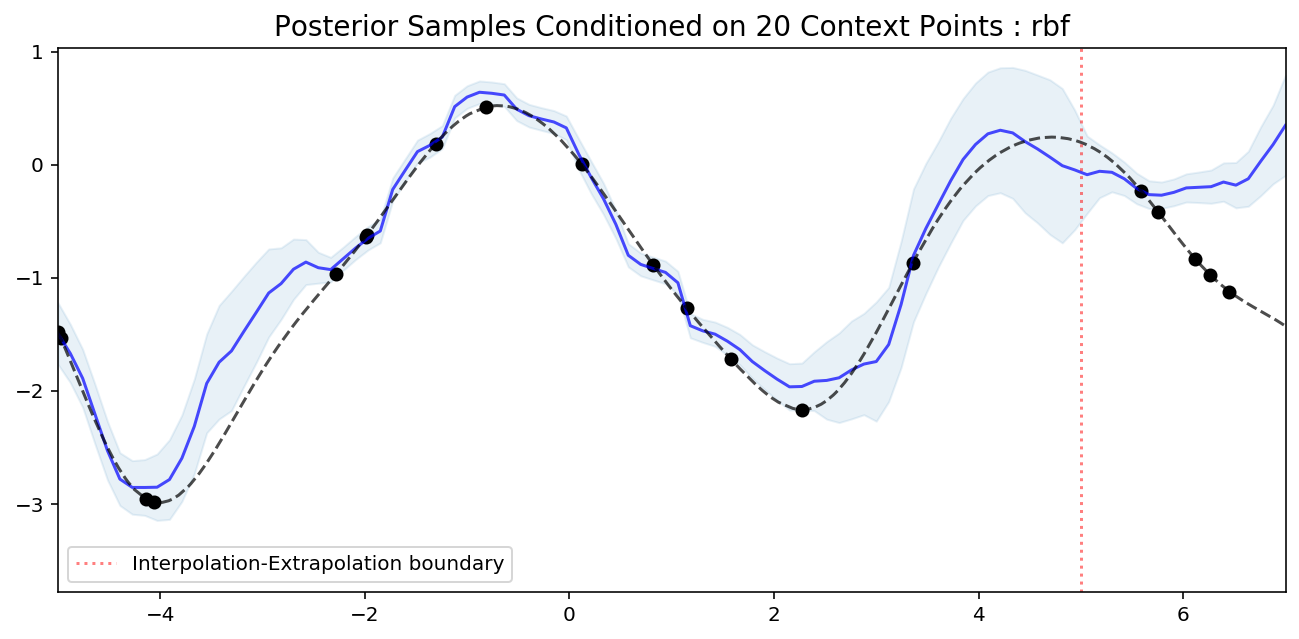

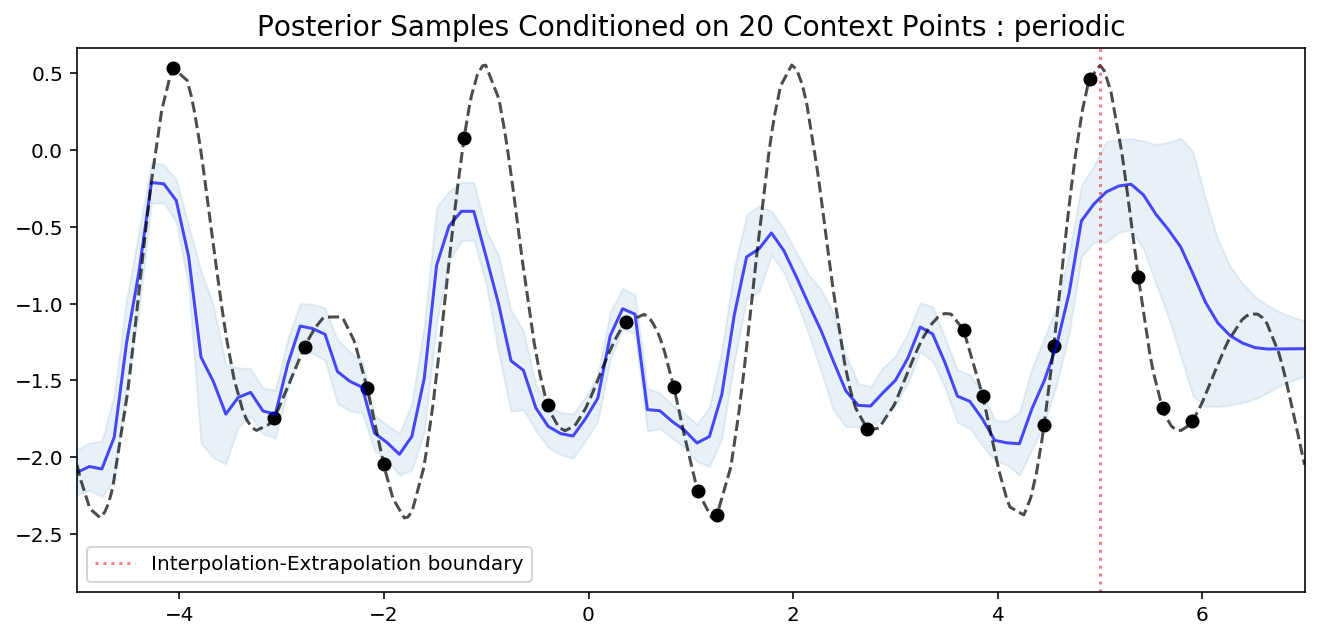

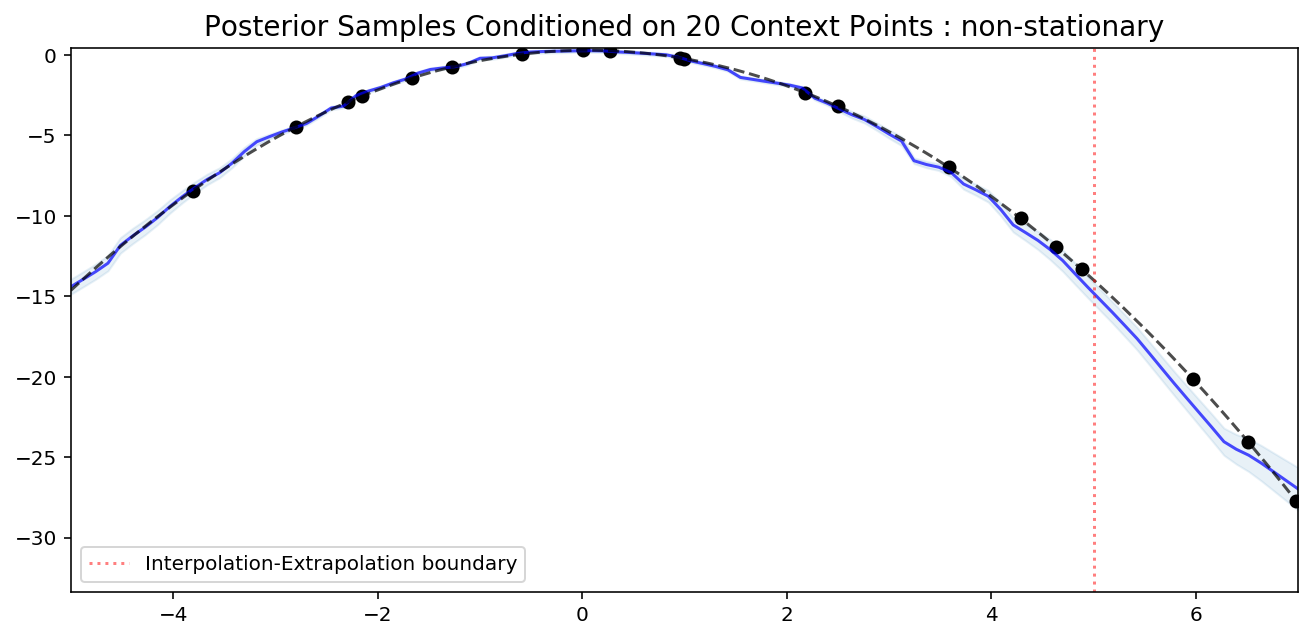

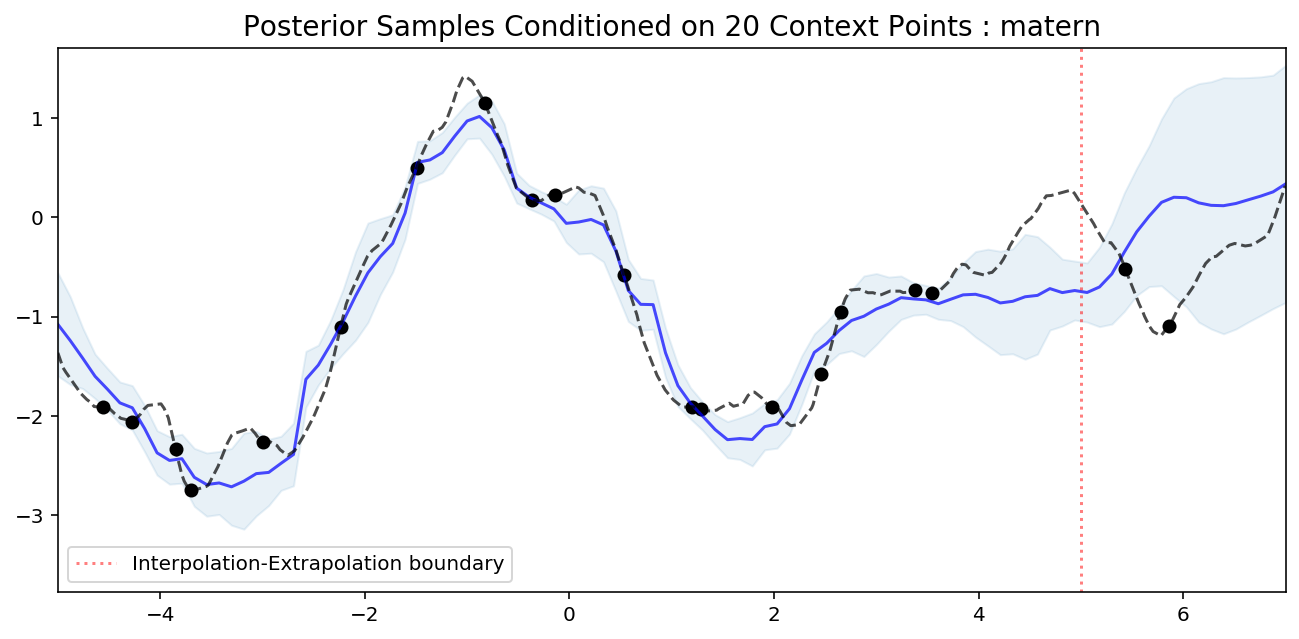

In [22]:
N_CNTXT = 20
for k,(neural_proc, dataset) in data_models.items():
    plot_posterior_samples(dataset, neural_proc, 
                           n_cntxt=N_CNTXT, 
                           test_min_max=EXTRAPOLATION_RANGE, 
                           n_points=2*N_POINTS,
                           n_samples=1,
                           title="Posterior Samples Conditioned on {} Context Points : {}".format(N_CNTXT, k))

We see that the predictions are not too bad.

**Good**:
- The standard devation does not collapse to the minimum value it can output (i.e. 0.1). 
- It is also relatively uncertain far from context points. This is even more true when extrapolating

**Bad**:
- it often underfits and the mean does not often pass through the context points (and the variance doesn't decrease at those points).
- periodicity pattern is not really periodic, which becomes clear when having a small number of context points and even more when extrapolating
- the variance is very small when extrapolating for periodic functions, although its predictions are very bad.